In [ ]:
# set up
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from scipy.stats import uniform, randint

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
!pip install tpot
from tpot import TPOTClassifier
from sklearn.utils import resample

from sklearn.tree import plot_tree
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# load data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("free4ever1/instagram-fake-spammer-genuine-accounts")

print("Path to dataset files:", path)

import os
print(os.listdir(path))
file_path = f"{path}/train.csv"
train = pd.read_csv(file_path)
print(train.head())
file_path = f"{path}/test.csv"
test = pd.read_csv(file_path)
print(test.head())

Path to dataset files: /root/.cache/kagglehub/datasets/free4ever1/instagram-fake-spammer-genuine-accounts/versions/1
['test.csv', 'train.csv']
   profile pic  nums/length username  fullname words  nums/length fullname  \
0            1                  0.27               0                   0.0   
1            1                  0.00               2                   0.0   
2            1                  0.10               2                   0.0   
3            1                  0.00               1                   0.0   
4            1                  0.00               2                   0.0   

   name==username  description length  external URL  private  #posts  \
0               0                  53             0        0      32   
1               0                  44             0        0     286   
2               0                   0             0        1      13   
3               0                  82             0        0     679   
4               0           

# **Data Preprocessing**

In [ ]:
# 1) handle missing values
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

# 2) feature engineering: use dummies to encode categorical features
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           576 non-null    int64  
 1   nums/length username  576 non-null    float64
 2   fullname words        576 non-null    int64  
 3   nums/length fullname  576 non-null    float64
 4   name==username        576 non-null    int64  
 5   description length    576 non-null    int64  
 6   external URL          576 non-null    int64  
 7   private               576 non-null    int64  
 8   #posts                576 non-null    int64  
 9   #followers            576 non-null    int64  
 10  #follows              576 non-null    int64  
 11  fake                  576 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 54.1 KB


**Heatmap**

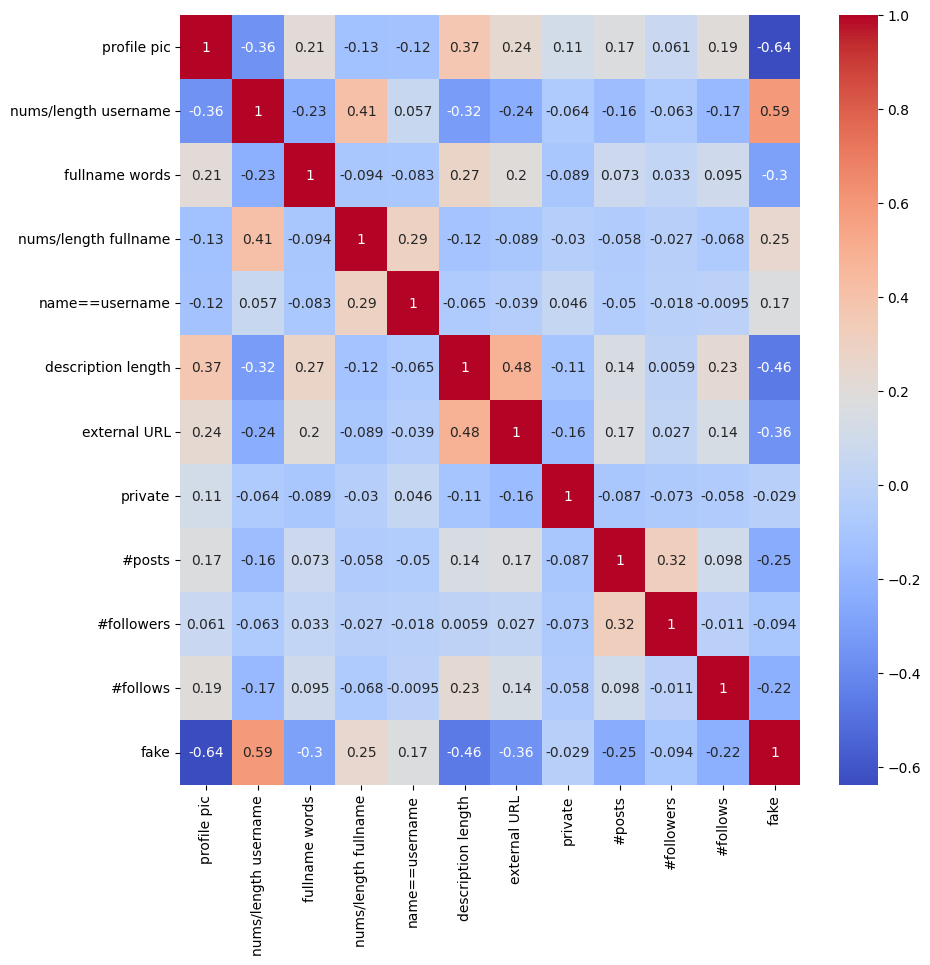

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')

plt.show()

**Plot the top three covariates with 'fake'**
- profile pic (negative cor)
- nums/length username (positive cor)
- description length (negative cor)

In [ ]:
train.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,5.760000e+02,576.000000,576.000000
mean,0.701389,0.163837,1.460069,0.036094,0.034722,22.623264,0.116319,0.381944,107.489583,8.530724e+04,508.381944,0.500000
std,0.458047,0.214096,1.052601,0.125121,0.183234,37.702987,0.320886,0.486285,402.034431,9.101485e+05,917.981239,0.500435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.900000e+01,57.500000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.505000e+02,229.500000,0.500000
75%,1.000000,0.310000,2.000000,0.000000,0.000000,34.000000,0.000000,1.000000,81.500000,7.160000e+02,589.500000,1.000000
max,1.000000,0.920000,12.000000,1.000000,1.000000,150.000000,1.000000,1.000000,7389.000000,1.533854e+07,7500.000000,1.000000


**Histogram**

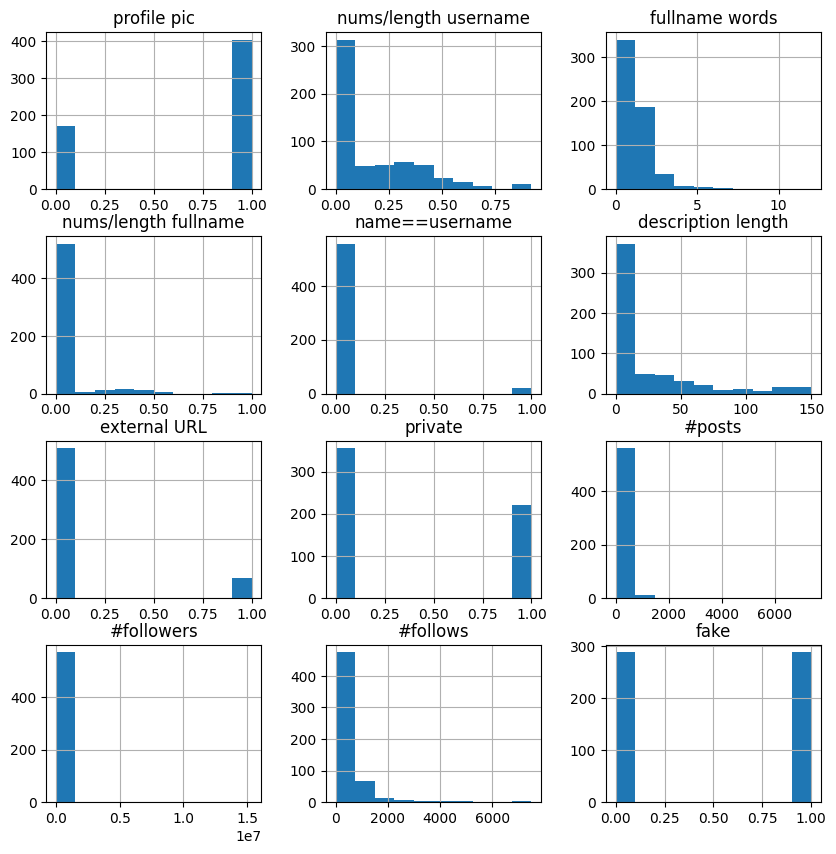

In [ ]:
train.hist(figsize=(10,10))
plt.show()

In [ ]:
X_train = train.drop(columns=['fake']) # we select all columns from the train except for the fake column - that is our target variable
y_train = train['fake']

X_test = test.drop(columns=['fake'])  # same process for test dataset
y_test = test['fake']

print(f'Training Features Shape: {X_train.shape}')
print(f'Test Features Shape: {X_test.shape}')

Training Features Shape: (576, 11)
Test Features Shape: (120, 11)


# **Model Development**

# **Regression-based**

**Logistic Regression (Baseline)**

Logistic Regression Accuracy: 91.67%
ROC-AUC Score: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91        60
           1       0.89      0.95      0.92        60

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.92      0.92       120



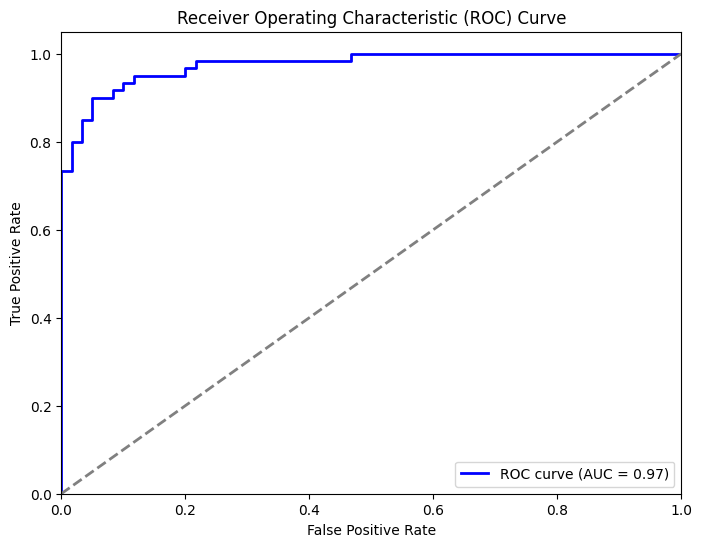

In [ ]:
log_reg_model = LogisticRegression(max_iter=2000, random_state=42)
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)
y_pred_prob = log_reg_model.predict_proba(X_test)[:, 1]

# Evaluate model
accuracy = accuracy_score(y_test, y_pred_log_reg)
print(f'Logistic Regression Accuracy: {accuracy * 100:.2f}%')
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC-AUC Score: {roc_auc:.2f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_reg))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



**Tuning for logistic regression**: For logistic regression, we want to involve evaluation strategies we mentioned in the slids - regularization techniques & cross-Validation & Hyperparameter Tuning & feature importance analysis.

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'C': 10, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
Logistic Regression Accuracy: 86.67%
Model Evaluation Metrics:
Accuracy: 86.67%
Precision: 0.87
Recall: 0.87
F1-Score: 0.87
ROC-AUC Score: 0.94


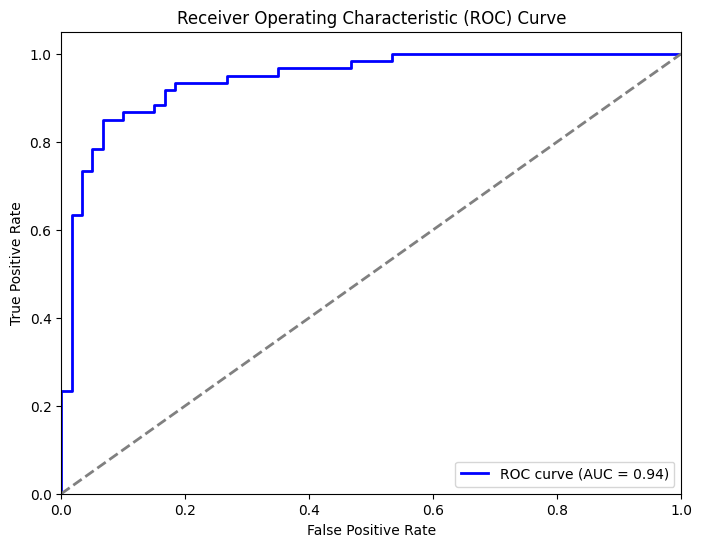

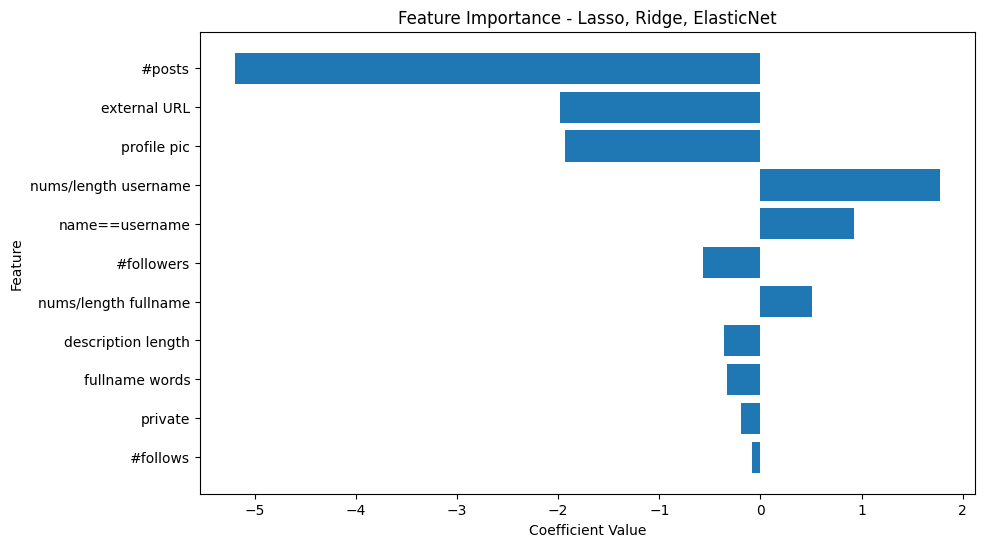

In [ ]:
# Scaling features for LR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Logistic Regression with L1, L2, and Elastic Net
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Lasso, Ridge, ElasticNet
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength, higher means less regularization
    'solver': ['saga'],  # 'saga' is compatible with l1, l2, and elasticnet penalties
}

# Add l1_ratio for ElasticNet only
elasticnet_param_grid = {
    'penalty': ['elasticnet'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.5, 0.9, 1.0]
}
param_grid.update(elasticnet_param_grid)

log_reg_model = LogisticRegression(max_iter=2000, random_state=42)

# 2. Cross-Validation with GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(estimator=log_reg_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# 3. Best Model and Hyperparameters
best_log_reg_model = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# 4. Evaluate Model using Cross-Validation and on Test Set
y_pred_log_reg = best_log_reg_model.predict(X_test_scaled)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred_log_reg)
print(f'Logistic Regression Accuracy: {accuracy * 100:.2f}%')

# Classification Report
report = classification_report(y_test, y_pred_log_reg, output_dict=True)

# Print Precision, Recall, F1-Score
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {report['1']['precision']:.2f}")
print(f"Recall: {report['1']['recall']:.2f}")
print(f"F1-Score: {report['1']['f1-score']:.2f}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, best_log_reg_model.predict_proba(X_test_scaled)[:, 1])
print(f'ROC-AUC Score: {roc_auc:.2f}')

# 5. Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_log_reg_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_value = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 6. Visualizing Feature Importances (For Lasso, Ridge, ElasticNet)
coefficients = best_log_reg_model.coef_[0]

# Sort features by importance (absolute value of coefficients)
indices = np.argsort(np.abs(coefficients))

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns[indices], coefficients[indices])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance - Lasso, Ridge, ElasticNet')
plt.show()


# Tree-Based Method

**Decision Tree**

Simplified tree without tuning

Decision Tree Accuracy: 87.50%
Precision: 0.92
Recall: 0.82
F1-Score: 0.87
ROC-AUC Score: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        60
           1       0.92      0.82      0.87        60

    accuracy                           0.88       120
   macro avg       0.88      0.88      0.87       120
weighted avg       0.88      0.88      0.87       120



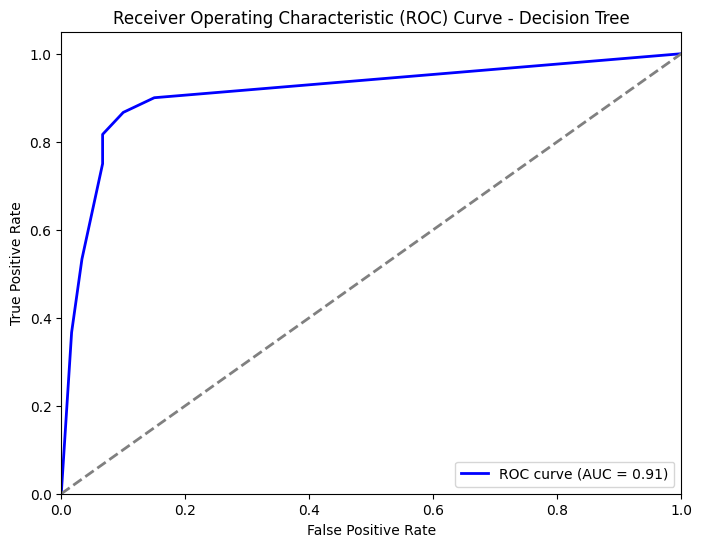

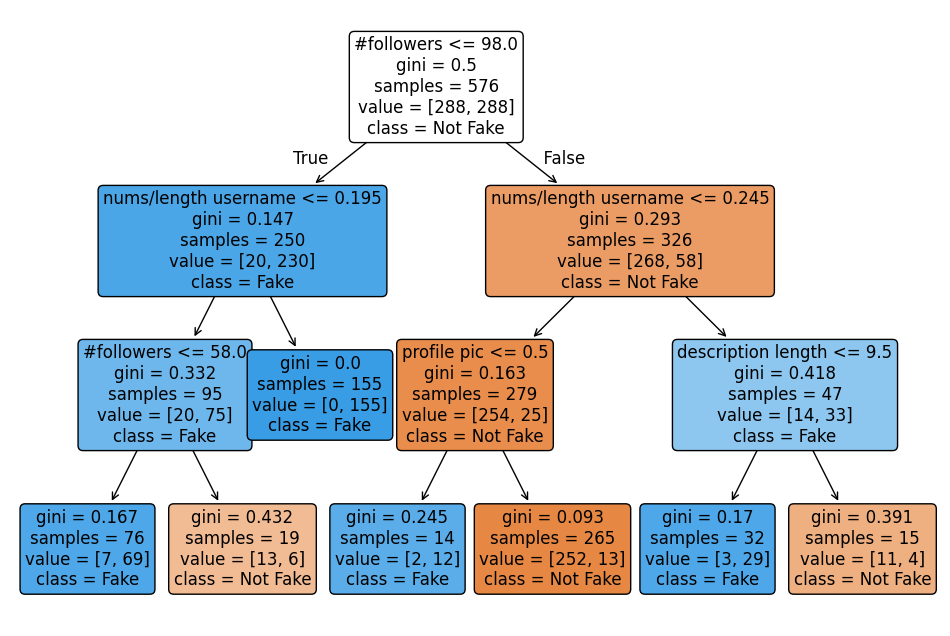

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_split=10, min_samples_leaf=5)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_pred_prob_dt = dt_model.predict_proba(X_test)[:, 1]

# Evaluate model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt * 100:.2f}%')
precision_dt = precision_score(y_test, y_pred_dt)
print(f'Precision: {precision_dt:.2f}')
recall_dt = recall_score(y_test, y_pred_dt)
print(f'Recall: {recall_dt:.2f}')
f1_dt = f1_score(y_test, y_pred_dt)
print(f'F1-Score: {f1_dt:.2f}')
roc_auc_dt = roc_auc_score(y_test, y_pred_prob_dt)
print(f'ROC-AUC Score: {roc_auc_dt:.2f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_prob_dt)
roc_auc_value_dt = auc(fpr_dt, tpr_dt)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

# Visualize decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=['Not Fake', 'Fake'], rounded=True, fontsize=12)
plt.show()

Trying out decision tree in default setting obtained similar scores

Decision Tree Accuracy: 89.17%
Precision: 0.91
Recall: 0.87
F1-Score: 0.89
ROC-AUC Score: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        60
           1       0.91      0.87      0.89        60

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120



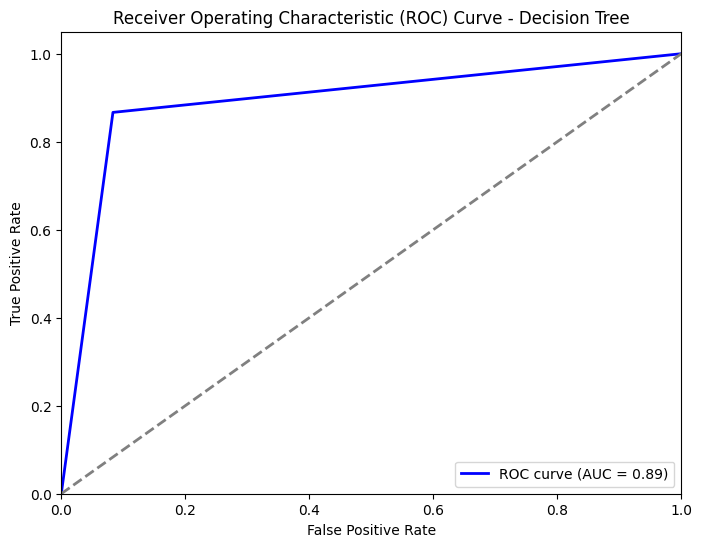

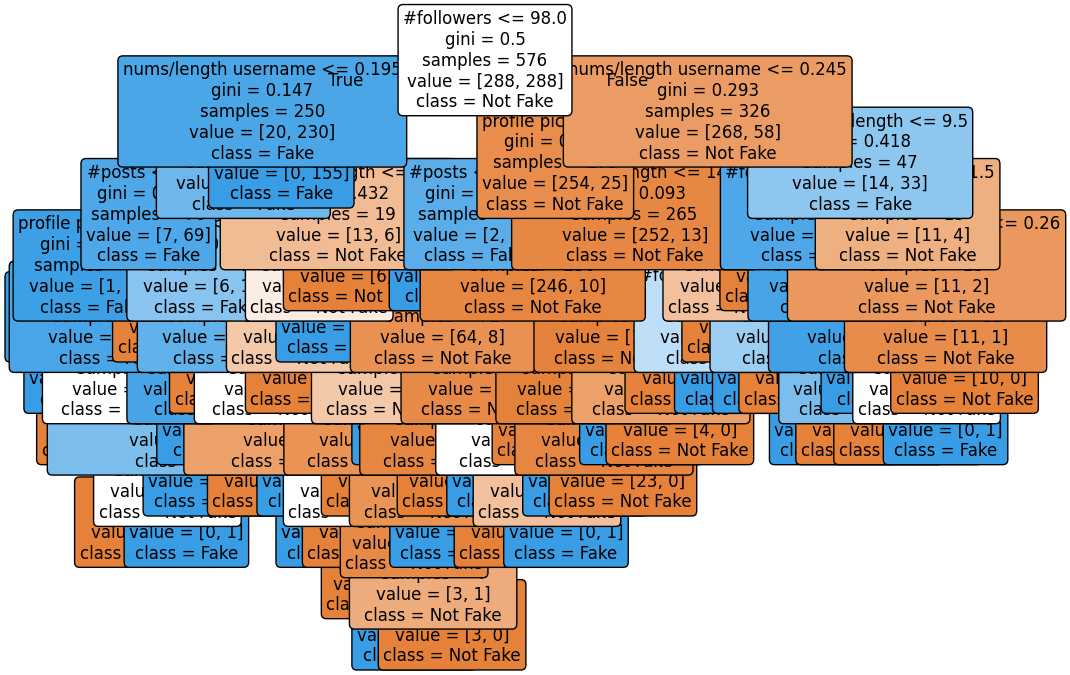

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_pred_prob_dt = dt_model.predict_proba(X_test)[:, 1]

# Evaluate model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt * 100:.2f}%')
precision_dt = precision_score(y_test, y_pred_dt)
print(f'Precision: {precision_dt:.2f}')
recall_dt = recall_score(y_test, y_pred_dt)
print(f'Recall: {recall_dt:.2f}')
f1_dt = f1_score(y_test, y_pred_dt)
print(f'F1-Score: {f1_dt:.2f}')
roc_auc_dt = roc_auc_score(y_test, y_pred_prob_dt)
print(f'ROC-AUC Score: {roc_auc_dt:.2f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_prob_dt)
roc_auc_value_dt = auc(fpr_dt, tpr_dt)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

# Visualize decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=['Not Fake', 'Fake'], rounded=True, fontsize=12)
plt.show()

**Tuning for decision tree (RandomizedSearchCV)**

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 3}
Best Decision Tree Accuracy (RandomizedSearch): 87.50%
Precision: 0.92
Recall: 0.82
F1-Score: 0.87
ROC-AUC Score: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        60
           1       0.92      0.82      0.87        60

    accuracy                           0.88       120
   macro avg       0.88      0.88      0.87       120
weighted avg       0.88      0.88      0.87       120



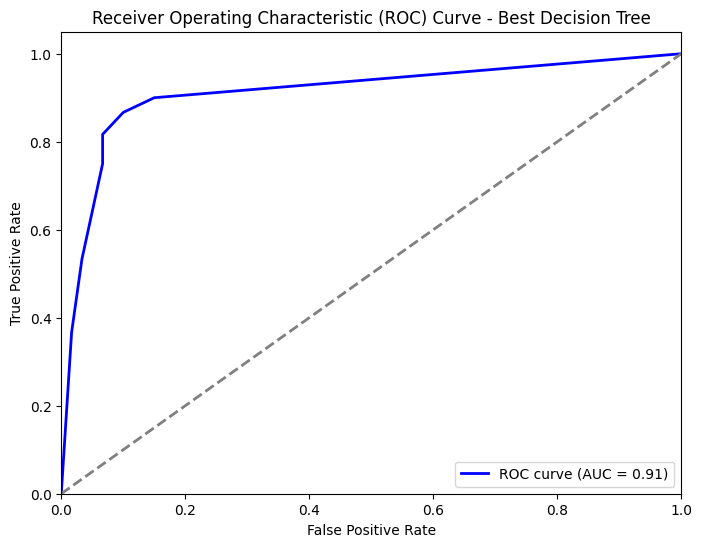

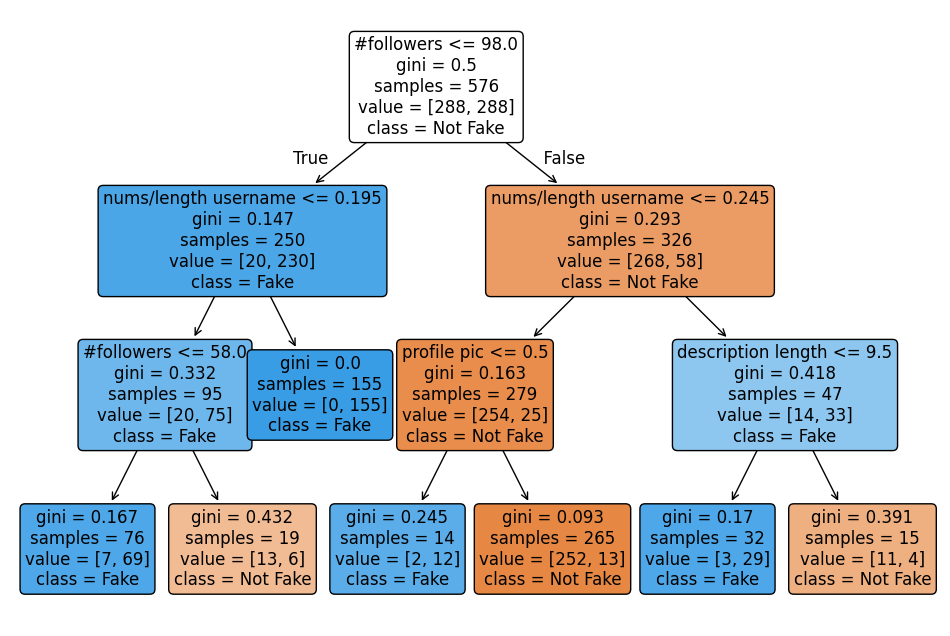

In [ ]:
param_dist = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

dt_model = DecisionTreeClassifier(random_state=42)
# RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=dt_model, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)
print(f"Best Parameters: {random_search.best_params_}")

# Evaluate the best model
best_model_random = random_search.best_estimator_
y_pred_best_random = best_model_random.predict(X_test)

y_pred_prob_best_random = best_model_random.predict_proba(X_test)[:, 1]


accuracy_best_random = accuracy_score(y_test, y_pred_best_random)
print(f"Best Decision Tree Accuracy (RandomizedSearch): {accuracy_best_random * 100:.2f}%")
precision_best_random = precision_score(y_test, y_pred_best_random)
print(f'Precision: {precision_best_random:.2f}')
recall_best_random = recall_score(y_test, y_pred_best_random)
print(f'Recall: {recall_best_random:.2f}')
f1_best_random = f1_score(y_test, y_pred_best_random)
print(f'F1-Score: {f1_best_random:.2f}')
roc_auc_best_random = roc_auc_score(y_test, y_pred_prob_best_random)
print(f'ROC-AUC Score: {roc_auc_best_random:.2f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_random))
fpr_best_random, tpr_best_random, thresholds_best_random = roc_curve(y_test, y_pred_prob_best_random)
roc_auc_value_best_random = auc(fpr_best_random, tpr_best_random)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_best_random, tpr_best_random, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value_best_random:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Best Decision Tree')
plt.legend(loc="lower right")
plt.show()


# Visualize the best decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_model_random, filled=True, feature_names=X_train.columns, class_names=['Not Fake', 'Fake'], rounded=True, fontsize=12)
plt.show()

**Random Forest**

Baseline model

Accuracy: 91.67%
Precision: 0.93
Recall: 0.90
F1-Score: 0.92
ROC-AUC Score: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        60
           1       0.93      0.90      0.92        60

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.92      0.92       120



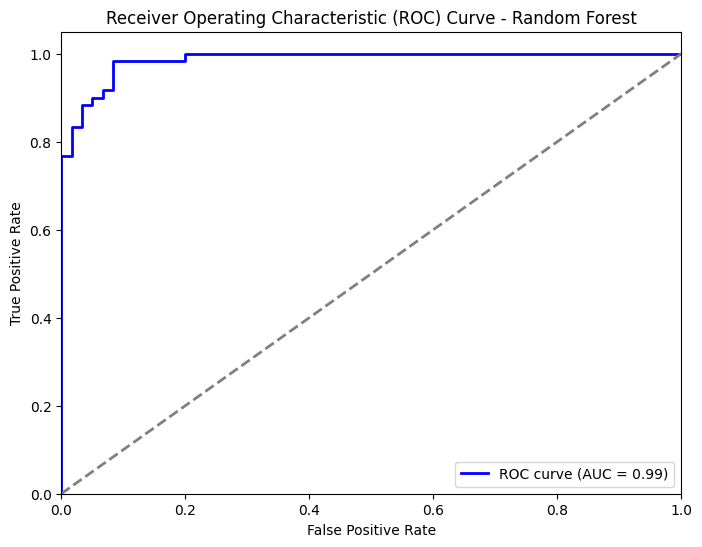

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1:.2f}')
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC-AUC Score: {roc_auc:.2f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()


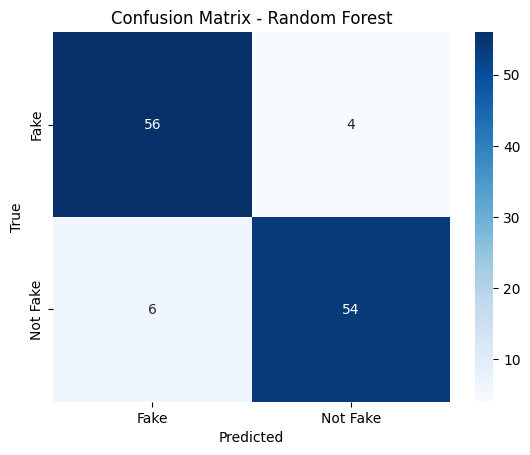

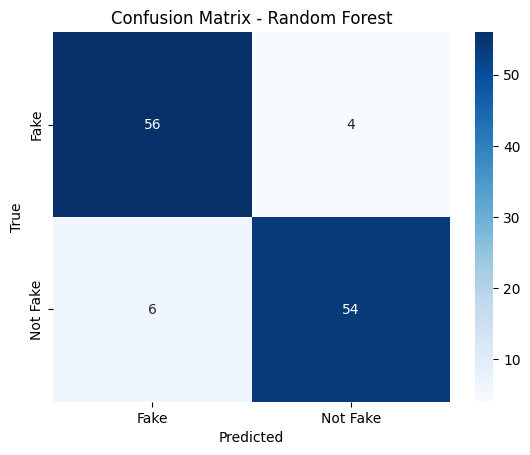

In [ ]:
# confusion matrix with RF
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Not Fake'], yticklabels=['Fake', 'Not Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()

**Tuning Random Forest (Using GridSearchCV)**

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Random Forest Accuracy: 92.50%
Precision: 0.93
Recall: 0.92
F1-Score: 0.92
ROC-AUC Score: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93        60
           1       0.93      0.92      0.92        60

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.92       120
weighted avg       0.93      0.93      0.92       120



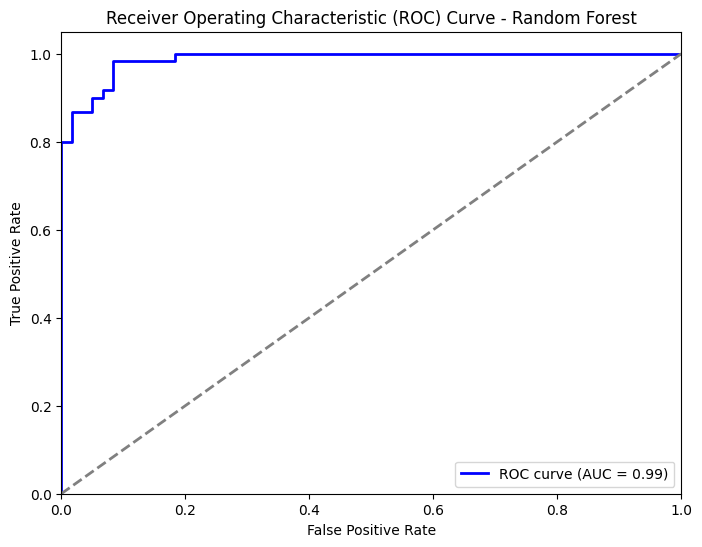

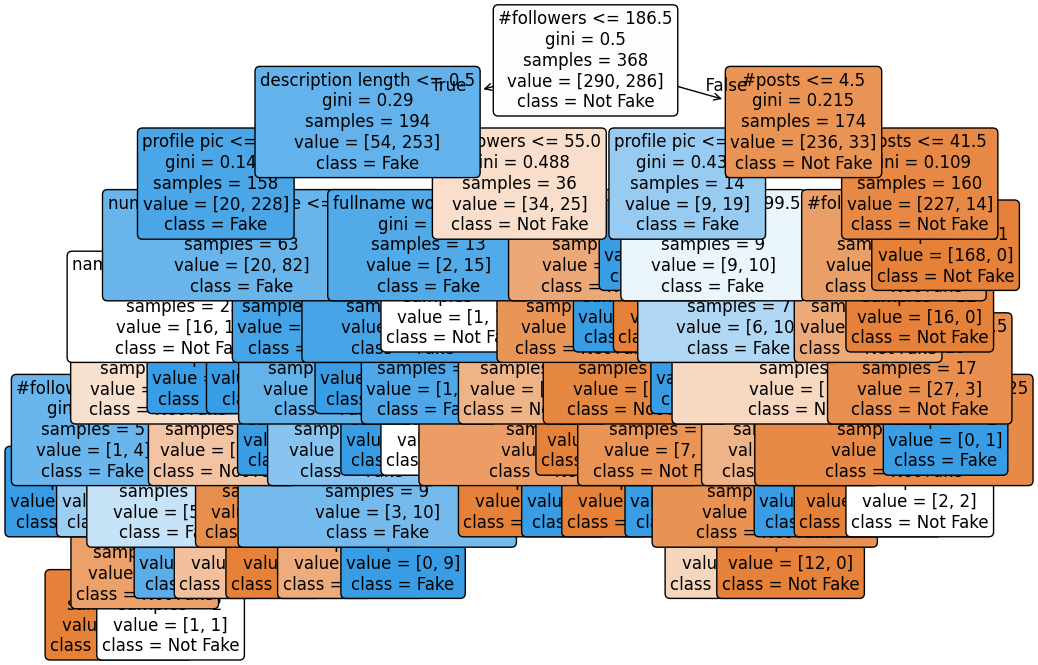

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}


rf_model = RandomForestClassifier(random_state=42)
# GridSearchCV with 3-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")


best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
y_pred_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Evaluate model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Best Random Forest Accuracy: {accuracy_rf * 100:.2f}%")
precision_rf = precision_score(y_test, y_pred_rf)
print(f'Precision: {precision_rf:.2f}')
recall_rf = recall_score(y_test, y_pred_rf)
print(f'Recall: {recall_rf:.2f}')
f1_rf = f1_score(y_test, y_pred_rf)
print(f'F1-Score: {f1_rf:.2f}')
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
print(f'ROC-AUC Score: {roc_auc_rf:.2f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
roc_auc_value_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

# Visualize one of the trees in the Random Forest
plt.figure(figsize=(12, 8))
plot_tree(best_rf_model.estimators_[0], filled=True, feature_names=X_train.columns, class_names=['Not Fake', 'Fake'], rounded=True, fontsize=12)
plt.show()


Param tuning using random search (randomly selects combinations of hyperparameters to test, faster than grid search)

In [ ]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']

# Initialize RandomForest
rf = RandomForestClassifier(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)


random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

best_rf = random_search.best_estimator_


y_pred_rf = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'max_depth': 33, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 14, 'n_estimators': 140}
Best cross-validation score: 0.9339
Test Accuracy: 0.8917
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        60
           1       0.89      0.90      0.89        60

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120



Bootstrapping for validating results

Bootstrap Model Evaluation: Mean Accuracy = 91.68%
Bootstrap Model Evaluation: Standard Deviation = 1.36%


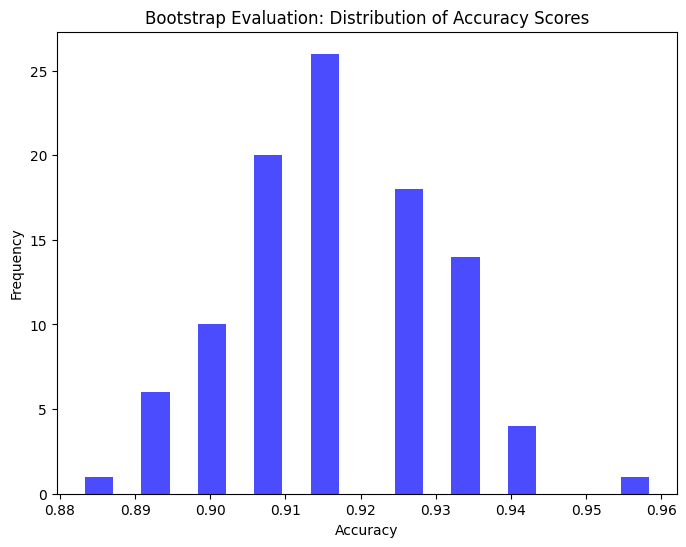

In [ ]:
# ------------------- Bootstrapping for Model Evaluation ------------------------
# Number of bootstrap samples, using 80% of data
n_iterations = 100
n_size = int(len(X_train) * 0.8)

bootstrap_accuracies = []


for i in range(n_iterations):
    X_resample, y_resample = resample(X_train, y_train, n_samples=n_size, random_state=i)

    best_rf_model.fit(X_resample, y_resample)
    y_pred_resample = best_rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_resample)

    bootstrap_accuracies.append(accuracy)

# Calculate the mean and sd of the bootstrap accuracy scores
mean_accuracy = np.mean(bootstrap_accuracies)
std_accuracy = np.std(bootstrap_accuracies)

print(f"Bootstrap Model Evaluation: Mean Accuracy = {mean_accuracy * 100:.2f}%")
print(f"Bootstrap Model Evaluation: Standard Deviation = {std_accuracy * 100:.2f}%")

# Plot the distribution of bootstrap accuracies
plt.figure(figsize=(8, 6))
plt.hist(bootstrap_accuracies, bins=20, color='blue', alpha=0.7)
plt.title('Bootstrap Evaluation: Distribution of Accuracy Scores')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

**Feature Importatnce using Random Forest**

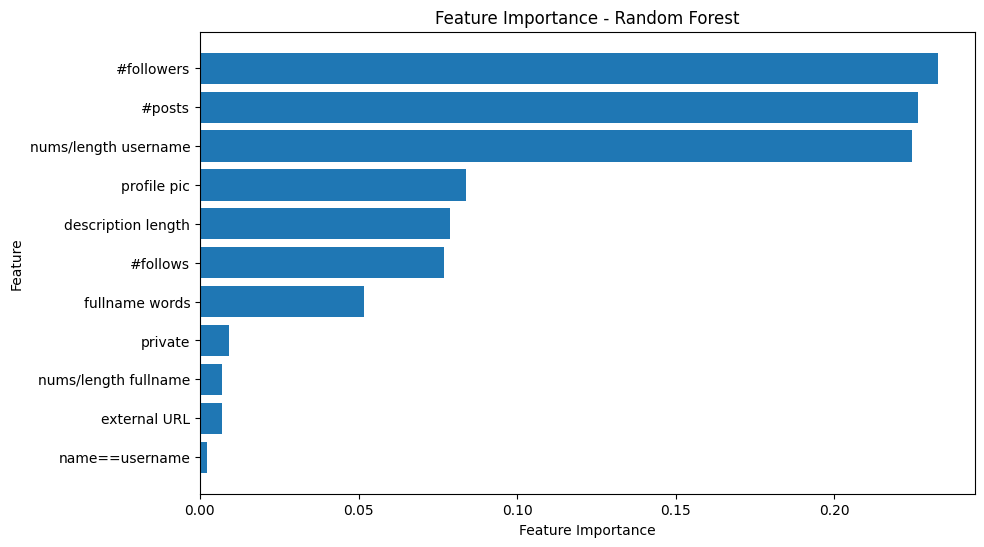

In [ ]:
features = X_train.columns
importances = best_rf_model.feature_importances_

# Sort the features by importance in ascending order
indices = np.argsort(importances)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(features[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest')
plt.show()



# **Boosting Method**

**Gradient Boosting**

Baseline model

Gradient Boosting Accuracy: 91.67%
Precision: 0.93
Recall: 0.90
F1-Score: 0.92
ROC-AUC Score: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        60
           1       0.93      0.90      0.92        60

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.92      0.92       120



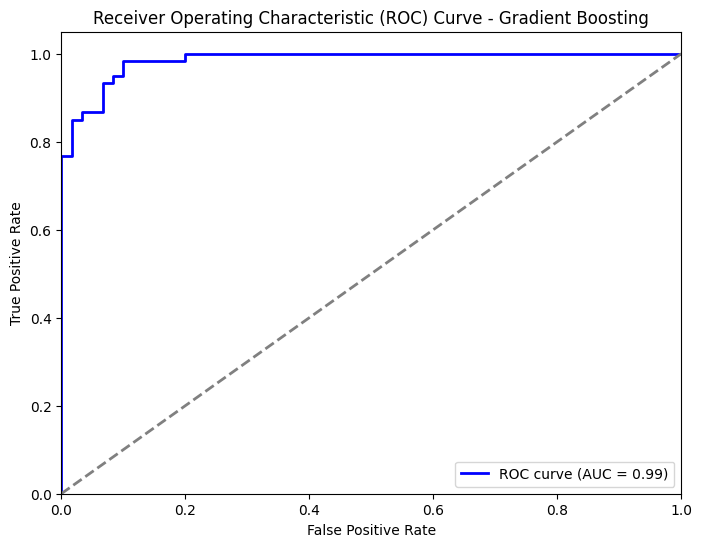

In [ ]:
# Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_pred_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluate model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Accuracy: {accuracy_gb * 100:.2f}%')
precision_gb = precision_score(y_test, y_pred_gb)
print(f'Precision: {precision_gb:.2f}')
recall_gb = recall_score(y_test, y_pred_gb)
print(f'Recall: {recall_gb:.2f}')
f1_gb = f1_score(y_test, y_pred_gb)
print(f'F1-Score: {f1_gb:.2f}')
roc_auc_gb = roc_auc_score(y_test, y_pred_prob_gb)
print(f'ROC-AUC Score: {roc_auc_gb:.2f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_prob_gb)
roc_auc_value_gb = auc(fpr_gb, tpr_gb)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value_gb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()



Param tuning using grid search

Fitting 2 folds for each of 64 candidates, totalling 128 fits
Best Parameters (Grid Search): {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}
Gradient Boosting Accuracy: 89.17%
Precision: 0.90
Recall: 0.88
F1-Score: 0.89
ROC-AUC Score: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89        60
           1       0.90      0.88      0.89        60

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120



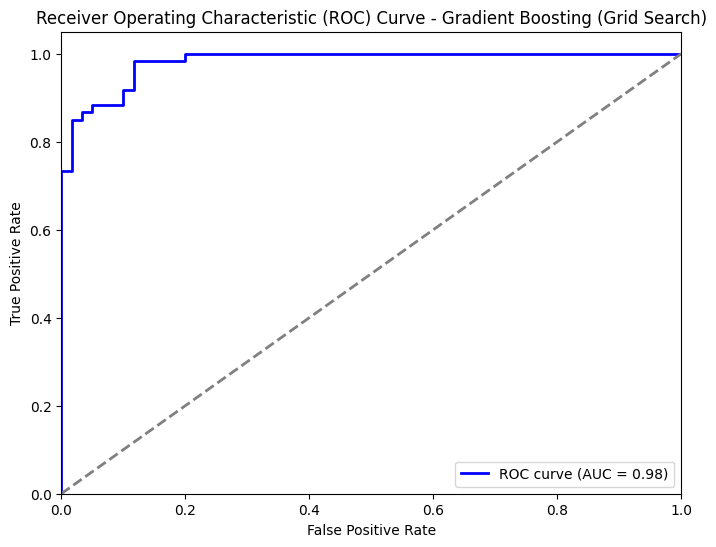

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Define a hyperparameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.7, 1.0]
}


gbc = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters (Grid Search):", grid_search.best_params_)

gbc_grid = grid_search.best_estimator_

gbc_grid.fit(X_train, y_train)

# Evaluate on the test set
y_test_pred = gbc_grid.predict(X_test)
y_pred_prob_gb = gbc_grid.predict_proba(X_test)[:, 1]  # Probability for ROC curve

# Calculate evaluation metrics
accuracy_gb = accuracy_score(y_test, y_test_pred)
precision_gb = precision_score(y_test, y_test_pred)
recall_gb = recall_score(y_test, y_test_pred)
f1_gb = f1_score(y_test, y_test_pred)
roc_auc_gb = roc_auc_score(y_test, y_pred_prob_gb)

# Print evaluation metrics
print(f'Gradient Boosting Accuracy: {accuracy_gb * 100:.2f}%')
print(f'Precision: {precision_gb:.2f}')
print(f'Recall: {recall_gb:.2f}')
print(f'F1-Score: {f1_gb:.2f}')
print(f'ROC-AUC Score: {roc_auc_gb:.2f}')
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Plot ROC curve
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_prob_gb)
roc_auc_value_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value_gb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gradient Boosting (Grid Search)')
plt.legend(loc="lower right")
plt.show()


Tuning with random search

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'learning_rate': 0.010104075399063163, 'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 458, 'subsample': 0.5823279265714709}
Gradient Boosting Test Accuracy (Random Search): 92.50%
Precision: 0.92
Recall: 0.93
F1-Score: 0.93
ROC-AUC Score: 0.99

Classification Report (Random Search):
              precision    recall  f1-score   support

           0       0.93      0.92      0.92        60
           1       0.92      0.93      0.93        60

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.92       120
weighted avg       0.93      0.93      0.92       120



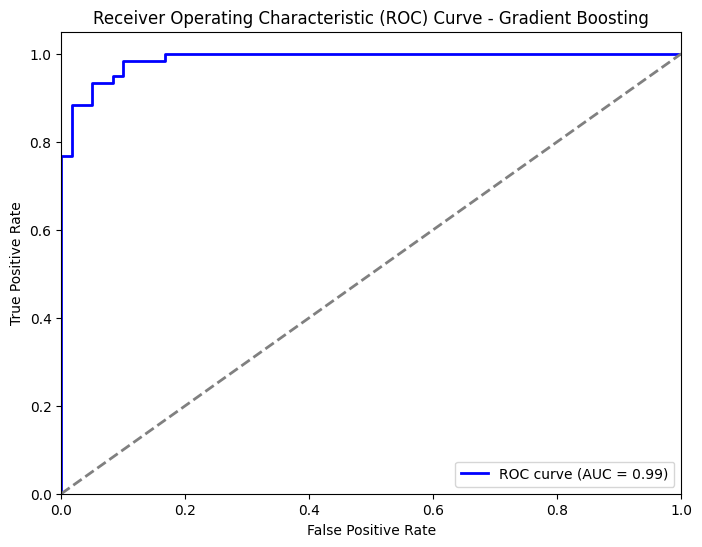

In [ ]:
# Hyperparameter distribution for random search
param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.5, 0.5)
}

gbc = GradientBoostingClassifier(random_state=42)

# Randomized Search with 3-fold cross-validation
random_search = RandomizedSearchCV(estimator=gbc, param_distributions=param_dist, n_iter=100, cv=3, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
gbc_random_search = GradientBoostingClassifier(**random_search.best_params_, random_state=42)

gbc_random_search.fit(X_train, y_train)
y_test_pred = gbc_random_search.predict(X_test)
y_pred_prob = gbc_random_search.predict_proba(X_test)[:, 1]


accuracy_random = accuracy_score(y_test, y_test_pred)
precision_random = precision_score(y_test, y_test_pred)
recall_random = recall_score(y_test, y_test_pred)
f1_random = f1_score(y_test, y_test_pred)
roc_auc_random = roc_auc_score(y_test, y_pred_prob)
print(f'Gradient Boosting Test Accuracy (Random Search): {accuracy_random * 100:.2f}%')
print(f'Precision: {precision_random:.2f}')
print(f'Recall: {recall_random:.2f}')
print(f'F1-Score: {f1_random:.2f}')
print(f'ROC-AUC Score: {roc_auc_random:.2f}')
print("\nClassification Report (Random Search):")
print(classification_report(y_test, y_test_pred))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()


**XGBoost**

In [ ]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb * 100:.2f}%')
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 92.50%
              precision    recall  f1-score   support

           0       0.93      0.92      0.92        60
           1       0.92      0.93      0.93        60

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.92       120
weighted avg       0.93      0.93      0.92       120



Tuning with grid search

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best Parameters (Grid Search): {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.7}
XGBoost Test Accuracy (Grid Search): 93.33%
Precision: 0.95
Recall: 0.92
F1-Score: 0.93
ROC-AUC Score: 0.99

Classification Report (Grid Search):
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        60
           1       0.95      0.92      0.93        60

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120



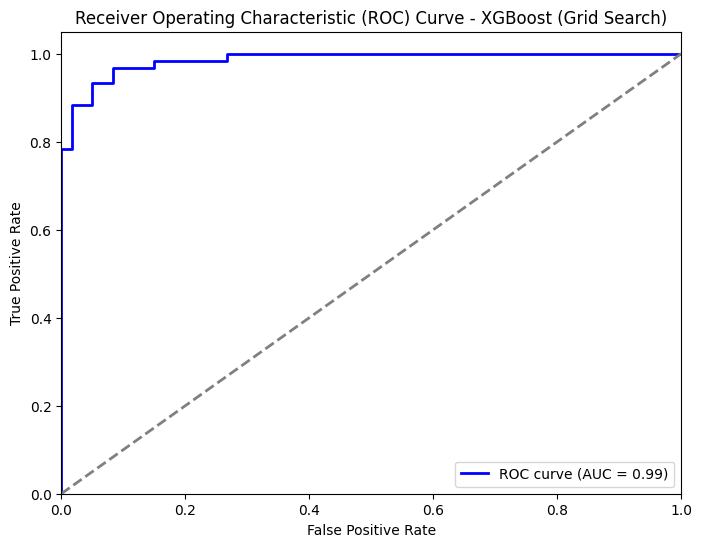

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5],
    'min_child_weight': [1, 3, 5]
}


xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# Perform Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)


print("Best Parameters (Grid Search):", grid_search.best_params_)
xgb_grid = grid_search.best_estimator_

xgb_grid.fit(X_train, y_train)

y_test_pred = xgb_grid.predict(X_test)
y_pred_prob = xgb_grid.predict_proba(X_test)[:, 1]


accuracy_xgb = accuracy_score(y_test, y_test_pred)
precision_xgb = precision_score(y_test, y_test_pred)
recall_xgb = recall_score(y_test, y_test_pred)
f1_xgb = f1_score(y_test, y_test_pred)
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob)

# evaluation metrics
print(f'XGBoost Test Accuracy (Grid Search): {accuracy_xgb * 100:.2f}%')
print(f'Precision: {precision_xgb:.2f}')
print(f'Recall: {recall_xgb:.2f}')
print(f'F1-Score: {f1_xgb:.2f}')
print(f'ROC-AUC Score: {roc_auc_xgb:.2f}')
print("\nClassification Report (Grid Search):")
print(classification_report(y_test, y_test_pred))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost (Grid Search)')
plt.legend(loc="lower right")
plt.show()


Tuning with random search

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters (Random Search): {'colsample_bytree': 0.9243450210052739, 'gamma': 0.6104397735033668, 'learning_rate': 0.11688935142309247, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 484, 'subsample': 0.8279351625419417}
XGBoost Test Accuracy (Random Search): 94.17%
Precision: 0.93
Recall: 0.95
F1-Score: 0.94
ROC-AUC Score: 0.99

Classification Report (Random Search):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        60
           1       0.93      0.95      0.94        60

    accuracy                           0.94       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120



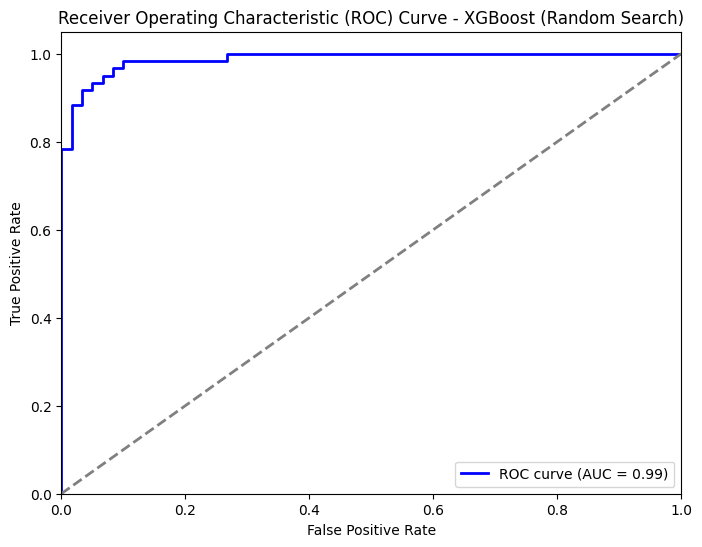

In [ ]:
# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 1.0),
    'colsample_bytree': uniform(0.6, 1.0),
    'gamma': uniform(0, 5),
    'min_child_weight': randint(1, 10)
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Perform Randomized Search with 3-fold cross-validation
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=50, cv=3, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters (Random Search):", random_search.best_params_)

xgb_random = random_search.best_estimator_
xgb_random.fit(X_train, y_train)

y_test_pred = xgb_random.predict(X_test)
y_pred_prob = xgb_random.predict_proba(X_test)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_test_pred)
precision_xgb = precision_score(y_test, y_test_pred)
recall_xgb = recall_score(y_test, y_test_pred)
f1_xgb = f1_score(y_test, y_test_pred)
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob)
print(f'XGBoost Test Accuracy (Random Search): {accuracy_xgb * 100:.2f}%')
print(f'Precision: {precision_xgb:.2f}')
print(f'Recall: {recall_xgb:.2f}')
print(f'F1-Score: {f1_xgb:.2f}')
print(f'ROC-AUC Score: {roc_auc_xgb:.2f}')
print("\nClassification Report (Random Search):")
print(classification_report(y_test, y_test_pred))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost (Random Search)')
plt.legend(loc="lower right")
plt.show()


# **Support Vector Method**

**Support vector machines**

Baseline model

In [ ]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluate model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm * 100:.2f}%')
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 89.17%
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        60
           1       0.89      0.90      0.89        60

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120



Tuning with random search

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import uniform, randint

# hyperparameter distribution for RandomizedSearchCV
param_dist = {
    'C': uniform(0.1, 100),
}

# Initialize the LinearSVC classifier (linear kernel)
svm_linear = LinearSVC(random_state=42, max_iter=10000)

# Perform Randomized Search with 3-fold cross-validation
random_search = RandomizedSearchCV(estimator=svm_linear, param_distributions=param_dist, n_iter=50, cv=3, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)


print("Best Parameters (Random Search):", random_search.best_params_)
svm_random = random_search.best_estimator_
svm_random.fit(X_train, y_train)
y_test_pred = svm_random.predict(X_test)

# accuracy
test_accuracy_random = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy (Random Search): {test_accuracy_random:.4f}")

# classification report
print("Classification Report (Random Search):\n", classification_report(y_test, y_test_pred))



Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters (Random Search): {'C': 37.55401188473625}
Test Accuracy (Random Search): 0.7500
Classification Report (Random Search):
               precision    recall  f1-score   support

           0       0.67      0.98      0.80        60
           1       0.97      0.52      0.67        60

    accuracy                           0.75       120
   macro avg       0.82      0.75      0.74       120
weighted avg       0.82      0.75      0.74       120



**Sequential Neural Network**

In [ ]:
import tensorflow as tf
import keras
print(keras.__version__)

3.5.0


Baseline model

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3999 - loss: 0.7647 - val_accuracy: 0.8917 - val_loss: 0.5754
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8311 - loss: 0.5675 - val_accuracy: 0.9000 - val_loss: 0.4692
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8811 - loss: 0.4418 - val_accuracy: 0.8833 - val_loss: 0.3968
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9061 - loss: 0.3553 - val_accuracy: 0.8833 - val_loss: 0.3599
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8878 - loss: 0.2945 - val_accuracy: 0.8833 - val_loss: 0.3406
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9260 - loss: 0.2438 - val_accuracy: 0.8750 - val_loss: 0.3362
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9188 - loss: 0.2335 - val_accuracy: 0.8667 - val_loss: 0.3309
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9252 - loss: 0.2328 - val_accuracy: 0.8833 - val_loss

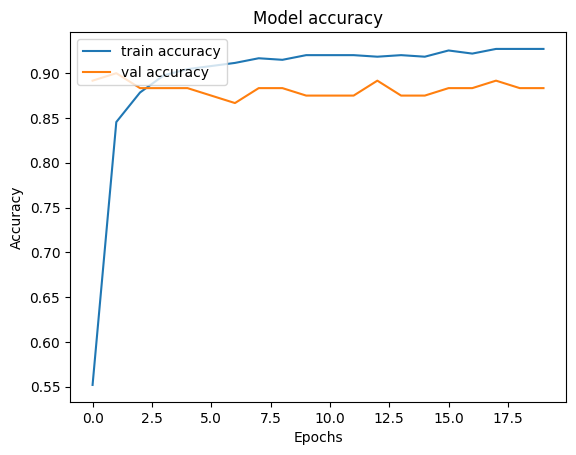

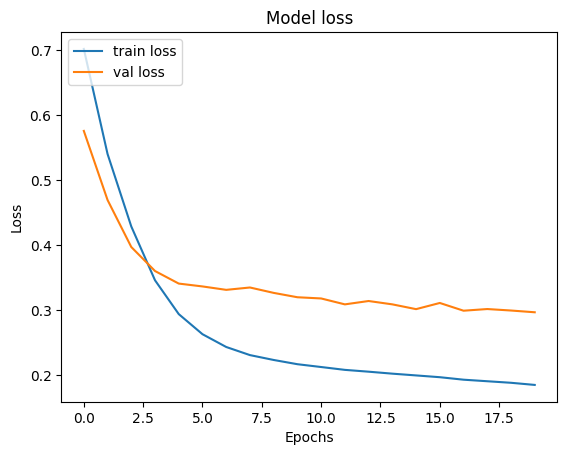

In [ ]:
# Step 1: Data preprocessing for the neural network
# Scaling the data - we scale it here because Neural Networks perform better when the data is scaled
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Build the sequential neural network
model = Sequential()

# Input layer: The input shape should match the number of features
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer with ReLU activation
model.add(Dense(32, activation='relu'))  # Hidden layer with ReLU activation
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification

# Step 3: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))

# Step 5: Evaluate the model
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype('int32')  # Threshold at 0.5 for binary classification

# accuracy
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network Accuracy: {accuracy_nn * 100:.2f}%")

# classification report
print(classification_report(y_test, y_pred_nn))


# Step 6: Plot training & validation accuracy values & loss values
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


Tuning by adding regularization, dropout, and hyperparameter tuning

Epoch 1/50
9/9 - 7s - 770ms/step - accuracy: 0.5035 - loss: 1.7361 - val_accuracy: 0.7250 - val_loss: 1.6112
Epoch 2/50
9/9 - 1s - 57ms/step - accuracy: 0.7708 - loss: 1.5305 - val_accuracy: 0.8667 - val_loss: 1.4451
Epoch 3/50
9/9 - 0s - 21ms/step - accuracy: 0.8594 - loss: 1.3719 - val_accuracy: 0.8750 - val_loss: 1.3070
Epoch 4/50
9/9 - 0s - 40ms/step - accuracy: 0.8837 - loss: 1.2256 - val_accuracy: 0.8750 - val_loss: 1.1892
Epoch 5/50
9/9 - 0s - 28ms/step - accuracy: 0.8993 - loss: 1.0930 - val_accuracy: 0.8750 - val_loss: 1.0927
Epoch 6/50
9/9 - 0s - 37ms/step - accuracy: 0.9010 - loss: 0.9941 - val_accuracy: 0.8750 - val_loss: 1.0120
Epoch 7/50
9/9 - 0s - 35ms/step - accuracy: 0.9080 - loss: 0.9083 - val_accuracy: 0.8750 - val_loss: 0.9428
Epoch 8/50
9/9 - 0s - 30ms/step - accuracy: 0.8976 - loss: 0.8397 - val_accuracy: 0.8667 - val_loss: 0.8801
Epoch 9/50
9/9 - 0s - 32ms/step - accuracy: 0.9080 - loss: 0.7645 - val_accuracy: 0.8750 - val_loss: 0.8269
Epoch 10/50
9/9 - 0s - 24ms

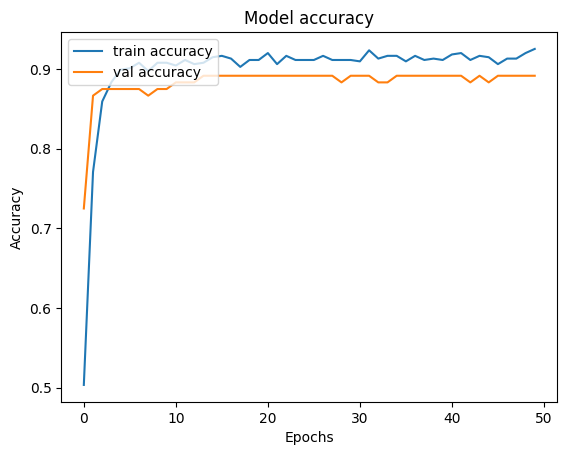

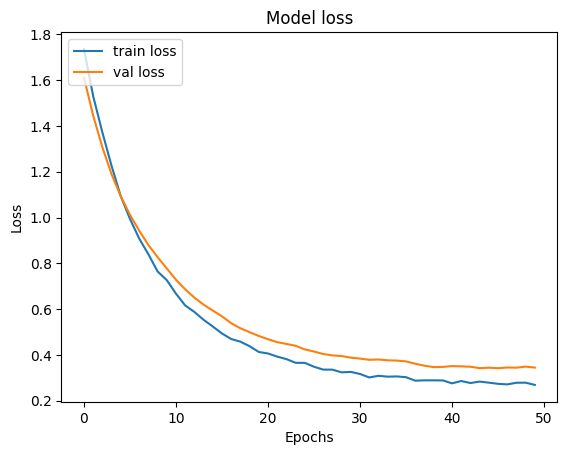

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


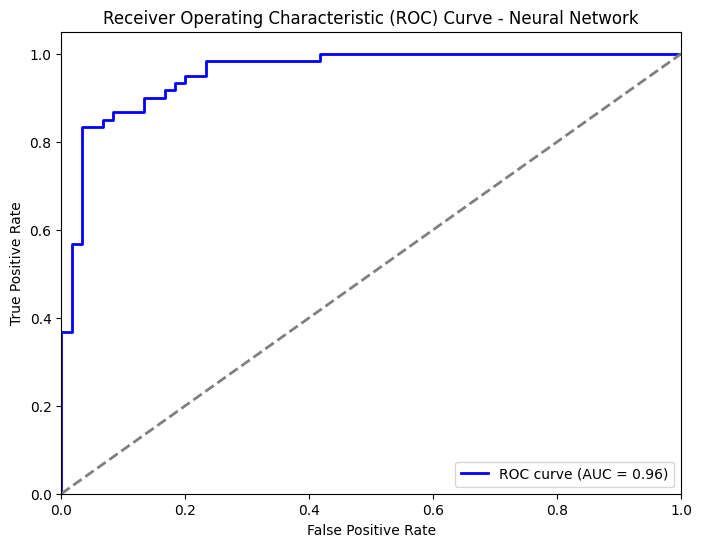

In [ ]:
# Step 1: Data preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Build the sequential neural network
model = Sequential()

# Input layer with L2 regularization
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Step 3: Compile the model
optimizer = Adam(learning_rate=0.001)  # Use a tuned learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 5: Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping],
    verbose=2
)

# Step 6: Evaluate the model
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype('int32')

# accuracy
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network Accuracy: {accuracy_nn * 100:.2f}%")

# classification report
print(classification_report(y_test, y_pred_nn))

# Step 7: Plot training & validation accuracy and loss
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


# Plot ROC-AUC Curve
y_pred_prob_nn = model.predict(X_test_scaled)

fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_prob_nn)
roc_auc_value_nn = auc(fpr_nn, tpr_nn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value_nn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Neural Network')
plt.legend(loc="lower right")
plt.show()
